In [1]:
%reload_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt
from nilearn import datasets, image, plotting

import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, image, plotting
from nilearn.datasets import load_mni152_template
from nilearn.maskers.nifti_spheres_masker import _apply_mask_and_get_affinity
from nilearn.masking import intersect_masks
from python.acnets.parcellations.dosenbach import load_dosenbach2010_masker
from python.acnets.parcellations.gordon import \
    fetch_atlas as fetch_gordon2014_atlas
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
%%script echo skipping...

smith_atlas = datasets.fetch_atlas_smith_2009()
rsn10_img = smith_atlas.rsn10

img = image.index_img(rsn10_img, 3)

coords = plotting.find_xyz_cut_coords(img)
coords

# display = plotting.plot_anat(cut_coords=coords,
#                              title='Regions from this network')

display = plotting.plot_stat_map(img, cut_coords=coords, colorbar=False,
                                 title='Showing one specific network')
# display.add_overlay(img,
#                     cmap=plotting.cm.alpha_cmap('r'))

plotting.show()

skipping...


In [123]:
from python.acnets.parcellations import difumo
difumo_masker, difumo_labels = difumo.load_masker('difumo_64_2mm', None)

difumo_labels['region_index'] = difumo_labels.reset_index().index
difumo_labels['network_index'] = difumo_labels.groupby('network').ngroup()

difumo_maps = image.load_img(difumo_masker.maps_img)


# plotting.plot_prob_atlas(img)
# plotting.show()

def compute_network_mask(regions, atlas='difumo_64_2mm', mni152=None):

    region_idxs = regions['region_index'].to_list()
    _imgs = image.index_img(difumo_maps, region_idxs)
    _imgs = image.binarize_img(_imgs)
    _imgs = list(image.iter_img(_imgs))
    _mask_img = intersect_masks(_imgs, threshold=0, connected=False)

    return _mask_img

    # if 'difumo_64_2mm' in atlas.lower():
    #     network_idx = regions['network_index'].unique()[0]
    #     _mask_img =  image.math_img(f'np.where(img == {network_idx}, 1.0, 0.0)',
    #                                 img=gordon_network_maps)
    #     # _mask = np.where(gordon_network_maps.get_fdata() == network_idx, 1.0, 0.0)
    #     # _mask_img = image.new_img_like(mni152_template, _mask)
    #     _mask_img = image.index_img(_mask_img, 0)

    # return _mask_img


difumo_masks = difumo_labels.groupby('network').progress_apply(compute_network_mask)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/image/image.py:756: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  return klass(data, affine, header=header)


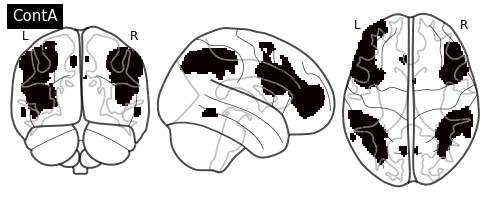

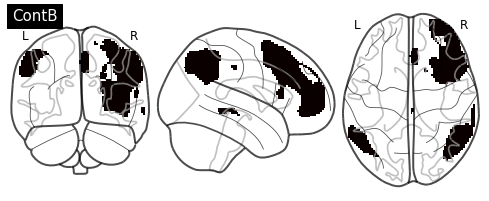

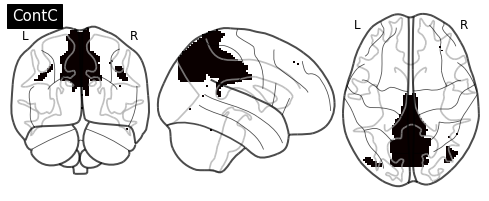

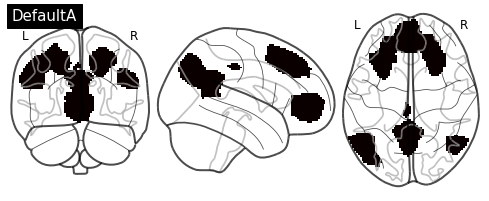

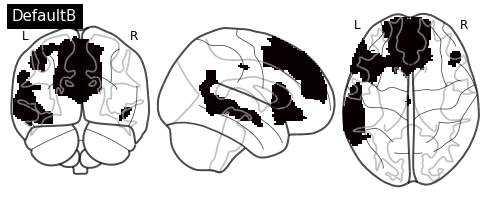

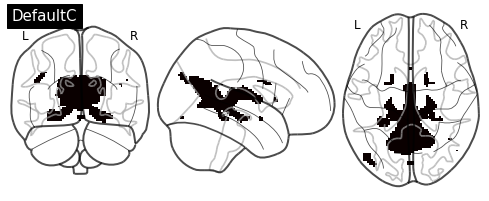

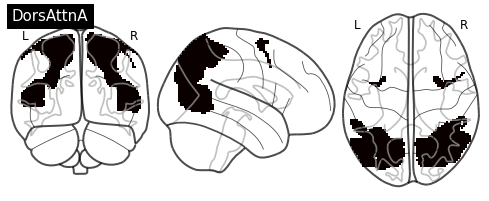

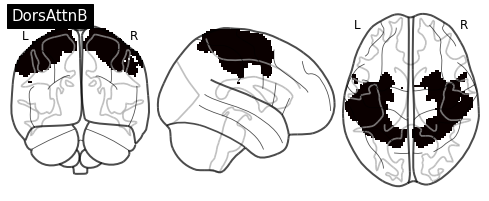

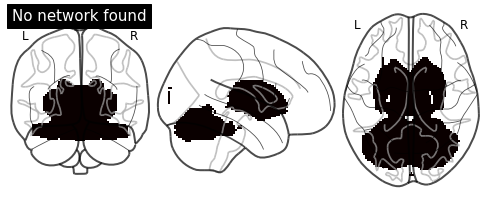

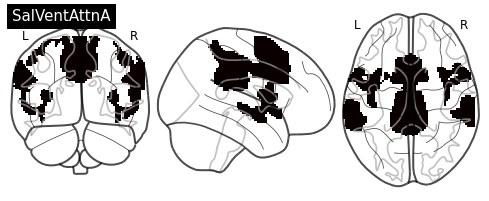

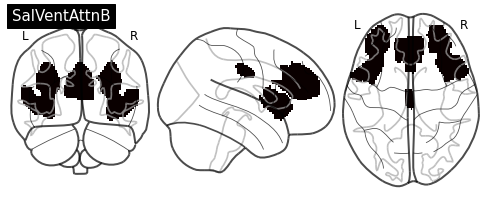

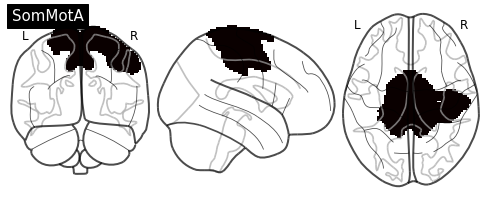

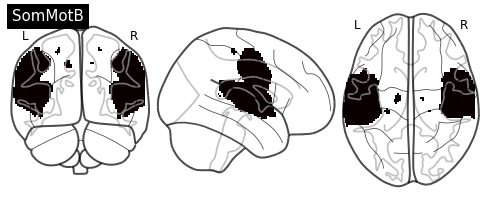

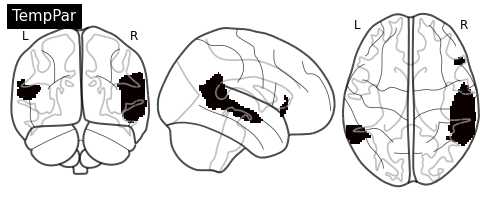

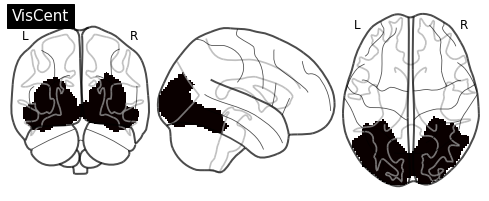

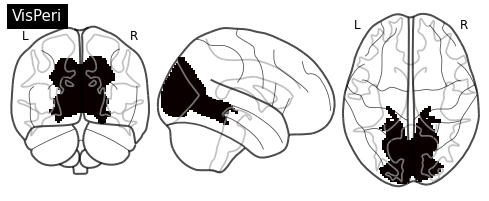

In [124]:
for network, _img in difumo_masks.iteritems():
    display = plotting.plot_glass_brain(_img, colorbar=False, title=network)
    plotting.show()

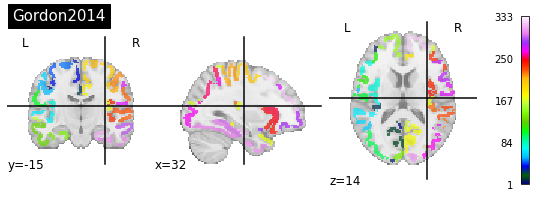

In [18]:
gordon2014_atlas = fetch_gordon2014_atlas()

plotting.plot_roi(gordon2014_atlas.maps, title='Gordon2014', colorbar=True)

plt.show()

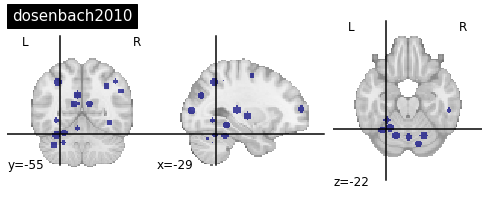

In [4]:
# create image for dosenbach atlas

_, dosenbach2010_labels = load_dosenbach2010_masker()
dosenbach2010_labels['network_index'] = dosenbach2010_labels.groupby('network').ngroup()

dosenbach2010_seeds = dosenbach2010_labels[['x','y','z']].values

# load MNI152 template
mni152_template = load_mni152_template(resolution=2)
mni152_data = mni152_template.get_fdata()[..., np.newaxis]
mni152_template = image.new_img_like(mni152_template, mni152_data)


_, A = _apply_mask_and_get_affinity(dosenbach2010_seeds, mni152_template, radius=5, allow_overlap=False)
_img = A.toarray().sum(axis=0).reshape(mni152_template.shape)
_img = image.new_img_like(mni152_template, _img)

plotting.plot_roi(_img, title='dosenbach2010', colorbar=False)
plt.show()
# plotting.plot_glass_brain(_img, title='dosenbach2010', colorbar=False)
# plt.show()


In [5]:
# Network Masks

gordon_labels = gordon2014_atlas.labels.reset_index()
gordon_labels['network_index'] = gordon_labels['network'].astype('category').cat.codes + 1

gordon_network_names = gordon_labels.network.astype('category').cat.categories.to_list()

def get_network_index(region_index):
    net_index = 0.0
    if region_index > 0:
        net_index = gordon_labels[['network_index']].values[int(region_index)-1,0]
        net_index = net_index.astype('float')

    return net_index

gordon_network_maps = image.load_img(gordon2014_atlas.maps).get_fdata()
gordon_network_maps = np.vectorize(get_network_index)(gordon_network_maps)
gordon_network_maps = image.new_img_like(gordon2014_atlas.maps, gordon_network_maps)
gordon_network_maps = image.resample_to_img(gordon_network_maps, mni152_template)

In [6]:
def compute_network_mask(regions, atlas, mni152=None):

    if 'gordon2014' in atlas.lower():
        network_idx = regions['network_index'].unique()[0]
        _mask_img =  image.math_img(f'np.where(img == {network_idx}, 1.0, 0.0)',
                                    img=gordon_network_maps)
        # _mask = np.where(gordon_network_maps.get_fdata() == network_idx, 1.0, 0.0)
        # _mask_img = image.new_img_like(mni152_template, _mask)
        _mask_img = image.index_img(_mask_img, 0)

    elif 'dosenbach2010' in atlas.lower():
        seeds = regions[['x','y','z']].values
        _, A = _apply_mask_and_get_affinity(seeds, mni152, radius=5, allow_overlap=False)
        _mask = A.toarray().sum(axis=0).reshape(mni152.shape)
        _mask_img = image.new_img_like(mni152, _mask)

    return _mask_img

gordon_network_masks = gordon_labels.groupby('network').progress_apply(
    compute_network_mask, atlas='gordon2014', mni152=mni152_template)

dosenbach_network_masks = dosenbach2010_labels.groupby('network').progress_apply(
    compute_network_mask, atlas='dosenbach2010', mni152=mni152_template)


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Auditory:
	sensorimotor	267


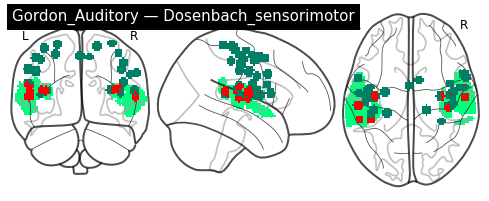

CinguloOperc:
	cingulo-opercular	413


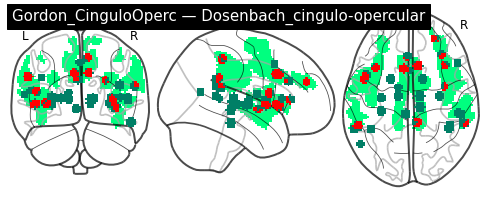

	sensorimotor	162


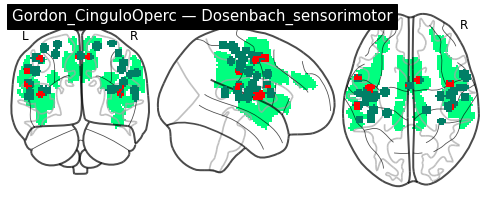

CinguloParietal:
	default	95


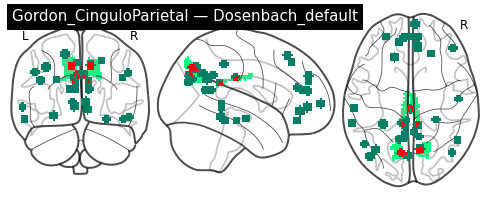

Default:
	default	703


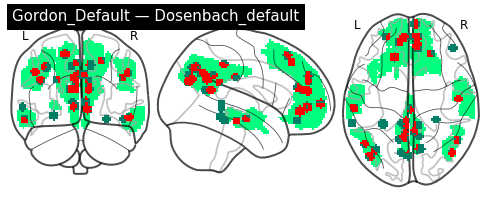

	fronto-parietal	48


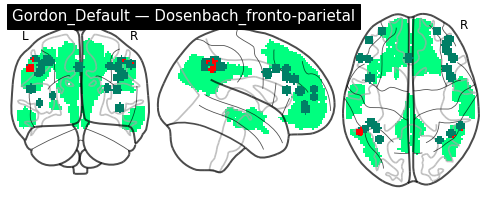

DorsalAttn:
	fronto-parietal	174


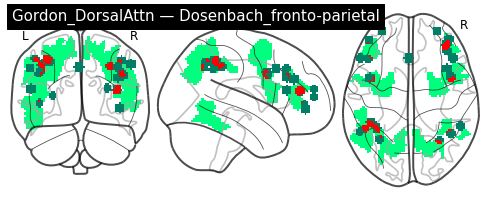

	occipital	58


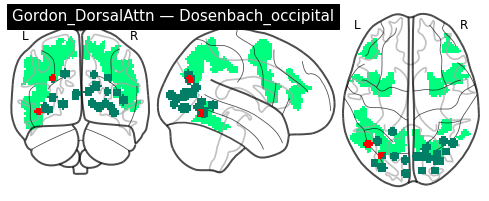

	sensorimotor	87


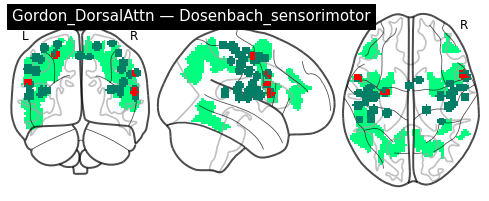

FrontoParietal:
	fronto-parietal	289


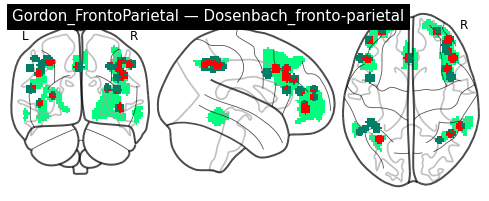

None:
RetrosplenialTemporal:
	default	167


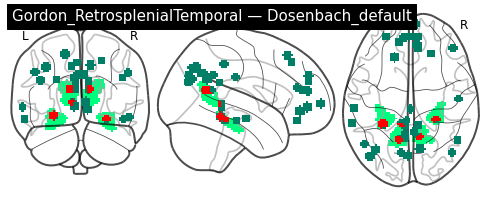

SMhand:
	sensorimotor	343


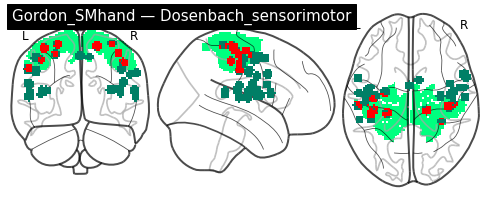

SMmouth:
	sensorimotor	295


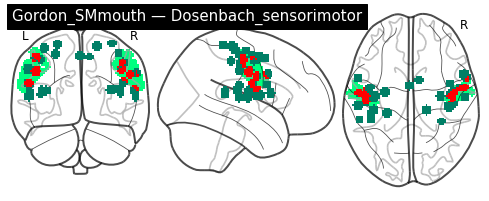

Salience:
VentralAttn:
	cingulo-opercular	107


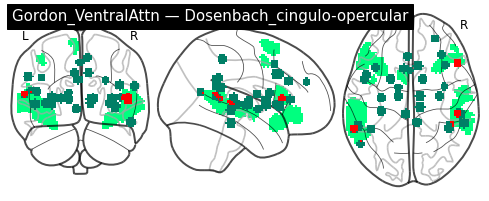

	default	73


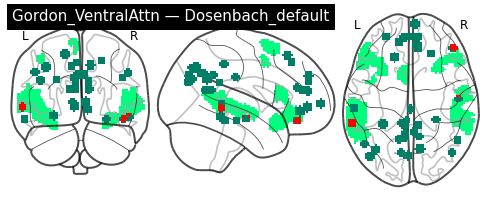

Visual:
	occipital	538


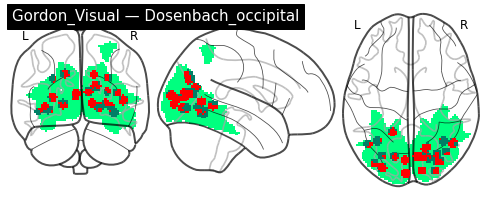

In [7]:
for gnet_name, gnet_mask in tqdm(gordon_network_masks.iteritems(), total=13):
    print(f'{gnet_name}:')
    for dnet_name, dnet_mask in dosenbach_network_masks.iteritems():
        overlap_mask = intersect_masks([gnet_mask, dnet_mask], connected=False)
        overlap_size = image.get_data(overlap_mask).sum()
        if overlap_size >= 40:
            print(f'\t{dnet_name}\t{overlap_size}')
            display = plotting.plot_glass_brain(
                gnet_mask,
                cmap='winter',
                zorder=0,
                title=f'Gordon_{gnet_name} — Dosenbach_{dnet_name}',
                colorbar=False)
            display.add_overlay(dnet_mask, cmap='summer', zorder=1)
            display.add_overlay(overlap_mask, cmap='autumn', zorder=10)
            plt.show()

In [1]:
def plot_network(network):
    plotting.plot_glass_brain(network.img, title=f'Dosenbach_{network.name}')
    plt.show()

dosenbach_network_masks.to_frame('img').progress_apply(plot_network, axis=1)

NameError: name 'plotting' is not defined